# Инструменты для работы с языком

... или зачем нужна предобработка.
[![Open In Colab](https://colab.research.google.com/assets/colab-badge.svg)](https://colab.research.google.com/drive/10_Aehfbxgr3fxXPgI1gM5BTU8yOy-Z4U)

## Задача: классификация твитов по тональности

У нас есть датасет из твитов, про каждый указано, как он эмоционально окрашен: положительно или отрицательно. Задача: предсказывать эмоциональную окраску.

Классификацию по тональности используют в рекомендательных системах, чтобы понять, понравилось ли людям кафе, кино, etc.

Скачиваем куски датасета ([источник](http://study.mokoron.com/)): [положительные](https://www.dropbox.com/s/fnpq3z4bcnoktiv/positive.csv?dl=0), [отрицательные](https://www.dropbox.com/s/r6u59ljhhjdg6j0/negative.csv).

In [1]:
# если у вас линукс / мак / collab или ещё какая-то среда, в которой работает wget, можно так:
!wget https://www.dropbox.com/s/fnpq3z4bcnoktiv/positive.csv
!wget https://www.dropbox.com/s/r6u59ljhhjdg6j0/negative.csv

--2024-09-09 18:10:17--  https://www.dropbox.com/s/fnpq3z4bcnoktiv/positive.csv
Resolving www.dropbox.com (www.dropbox.com)... 162.125.2.18, 2620:100:6017:18::a27d:212
Connecting to www.dropbox.com (www.dropbox.com)|162.125.2.18|:443... connected.
HTTP request sent, awaiting response... 302 Found
Location: https://www.dropbox.com/scl/fi/6mg7rw3wltux83q2o4ah4/positive.csv?rlkey=cvruhzofza9kkfxwzyp2vskfd [following]
--2024-09-09 18:10:18--  https://www.dropbox.com/scl/fi/6mg7rw3wltux83q2o4ah4/positive.csv?rlkey=cvruhzofza9kkfxwzyp2vskfd
Reusing existing connection to www.dropbox.com:443.
HTTP request sent, awaiting response... 302 Found
Location: https://uc2954d258b9e402f5b459bf182d.dl.dropboxusercontent.com/cd/0/inline/CaSyUN9p0FRCU5XVaNPnHK5tk3j5z6-zMPTS8Meu2izLDPvEsBLgTukuYGQE5FlhIduRMz1WJohHySQ5_dImMXjws4vob6sm-fcsAPdP4Q2hchk2532cVdlokobH4Ul3NI8/file# [following]
--2024-09-09 18:10:19--  https://uc2954d258b9e402f5b459bf182d.dl.dropboxusercontent.com/cd/0/inline/CaSyUN9p0FRCU5XVaNPnHK

In [2]:
import pandas as pd
import numpy as np
from sklearn.metrics import *
from sklearn.model_selection import train_test_split
from sklearn.pipeline import Pipeline

In [5]:
# считываем данные и заполняем общий датасет
positive = pd.read_csv('positive.csv', sep=';', usecols=[3], names=['text'])
positive['label'] = ['positive'] * len(positive)
negative = pd.read_csv('negative.csv', sep=';', usecols=[3], names=['text'])
negative['label'] = ['negative'] * len(negative)
df = pd.concat([positive,negative])

In [6]:
df.tail()

,text,label
111918,Но не каждый хочет что то исправлять:( http://...,negative
111919,скучаю так :-( только @taaannyaaa вправляет мо...,negative
111920,"Вот и в школу, в говно это идти уже надо(",negative
111921,"RT @_Them__: @LisaBeroud Тауриэль, не грусти :...",negative
111922,Такси везет меня на работу. Раздумываю приплат...,negative


In [7]:
x_train, x_test, y_train, y_test = train_test_split(df.text, df.label)

## Baseline: классификация необработанных n-грамм

### Векторизаторы

In [8]:
from sklearn.linear_model import LogisticRegression # можно заменить на любимый классификатор
from sklearn.feature_extraction.text import CountVectorizer

Что такое n-граммы:

In [9]:
from nltk import ngrams

In [10]:
sent = 'Если б мне платили каждый раз'.split()
list(ngrams(sent, 1)) # униграммы

[('Если',), ('б',), ('мне',), ('платили',), ('каждый',), ('раз',)]

In [11]:
list(ngrams(sent, 2)) # биграммы

[('Если', 'б'),
 ('б', 'мне'),
 ('мне', 'платили'),
 ('платили', 'каждый'),
 ('каждый', 'раз')]

In [12]:
list(ngrams(sent, 3)) # триграммы

[('Если', 'б', 'мне'),
 ('б', 'мне', 'платили'),
 ('мне', 'платили', 'каждый'),
 ('платили', 'каждый', 'раз')]

In [13]:
list(ngrams(sent, 5)) # ... пентаграммы?

[('Если', 'б', 'мне', 'платили', 'каждый'),
 ('б', 'мне', 'платили', 'каждый', 'раз')]

Самый простой способ извлечь признаки из текстовых данных -- векторизаторы: `CountVectorizer` и `TfidfVectorizer`

Объект `CountVectorizer` делает простую вещь:
* строит для каждого документа (каждой пришедшей ему строки) вектор размерности `n`, где `n` -- количество слов или n-грамм во всём корпусе
* заполняет каждый i-тый элемент количеством вхождений слова в данный документ

In [14]:
vec = CountVectorizer(ngram_range=(1, 1))
bow = vec.fit_transform(x_train) # bow -- bag of words (мешок слов)

ngram_range отвечает за то, какие n-граммы мы используем в качестве признаков:<br/>
ngram_range=(1, 1) -- униграммы<br/>
ngram_range=(3, 3) -- триграммы<br/>
ngram_range=(1, 3) -- униграммы, биграммы и триграммы.

В vec.vocabulary_ лежит словарь: мэппинг слов к их индексам:

In [15]:
list(vec.vocabulary_.items())[:10]

[('какие', 142499),
 ('то', 222032),
 ('однообразные', 172438),
 ('дни', 126126),
 ('пошли', 191516),
 ('надо', 162234),
 ('внести', 113258),
 ('разнообразие', 200485),
 ('нет', 167434),
 ('наркотики', 163885)]

In [16]:
clf = LogisticRegression(random_state=42)
clf.fit(bow, y_train)

/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_logistic.py:460: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


LogisticRegression(random_state=42)

In [17]:
pred = clf.predict(vec.transform(x_test))
print(classification_report(pred, y_test))

              precision    recall  f1-score   support

    negative       0.76      0.76      0.76     27943
    positive       0.77      0.76      0.77     28766

    accuracy                           0.76     56709
   macro avg       0.76      0.76      0.76     56709
weighted avg       0.76      0.76      0.76     56709



Попробуем сделать то же самое для триграмм:

In [18]:
vec = CountVectorizer(ngram_range=(1, 3))
bow = vec.fit_transform(x_train)
clf = LogisticRegression(random_state=42)
clf.fit(bow, y_train)
pred = clf.predict(vec.transform(x_test))
print(classification_report(pred, y_test))

KeyboardInterrupt: 

(как вы думаете, почему в результатах теперь такой разброс по сравнению с униграммами?)

## TF-IDF векторизация

`TfidfVectorizer` делает то же, что и `CountVectorizer`, но в качестве значений – tf-idf каждого слова.

Как считается tf-idf:

TF (term frequency) – относительная частотность слова в документе:
$$ TF(t,d) = \frac{n_t}{\sum_k n_k} $$

`t` -- слово (term), `d` -- документ, $n_t$ -- количество вхождений слова, $n_k$ -- количество вхождений остальных слов

IDF (inverse document frequency) – обратная частота документов, в которых есть это слово:
$$ IDF(t, D) = \mbox{log} \frac{|D|}{|{d : t \in d}|} $$

`t` -- слово (term), `D` -- коллекция документов

Перемножаем их:
$$TFIDF_(t,d,D) = TF(t,d) \times IDF(i, D)$$

Сакральный смысл – если слово часто встречается в одном документе, но в целом по корпусу встречается в небольшом
количестве документов, у него высокий TF-IDF.

In [19]:
from sklearn.feature_extraction.text import TfidfVectorizer

In [20]:
vec = TfidfVectorizer(ngram_range=(1, 1))
bow = vec.fit_transform(x_train)
clf = LogisticRegression(random_state=42)
clf.fit(bow, y_train)
pred = clf.predict(vec.transform(x_test))
print(classification_report(pred, y_test))

/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_logistic.py:460: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


              precision    recall  f1-score   support

    negative       0.73      0.77      0.75     26663
    positive       0.78      0.75      0.77     30046

    accuracy                           0.76     56709
   macro avg       0.76      0.76      0.76     56709
weighted avg       0.76      0.76      0.76     56709



В этот раз получилось хуже :( Вернёмся к `CountVectorizer`.

## Токенизация

Токенизировать -- значит, поделить текст на слова, или *токены*.

Самый наивный способ токенизировать текст -- разделить с помощью `split`. Но `split` упускает очень много всего, например, банально не отделяет пунктуацию от слов. Кроме этого, есть ещё много менее тривиальных проблем. Поэтому лучше использовать готовые токенизаторы.

In [21]:
import nltk
nltk.download('punkt')
from nltk.tokenize import word_tokenize

[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt.zip.


In [22]:
example = 'Но не каждый хочет что-то исправлять:('
word_tokenize(example)

['Но', 'не', 'каждый', 'хочет', 'что-то', 'исправлять', ':', '(']

В nltk вообще есть довольно много токенизаторов:

In [23]:
from nltk import tokenize
dir(tokenize)[:16]

['BlanklineTokenizer',
 'LegalitySyllableTokenizer',
 'LineTokenizer',
 'MWETokenizer',
 'NLTKWordTokenizer',
 'PunktSentenceTokenizer',
 'RegexpTokenizer',
 'ReppTokenizer',
 'SExprTokenizer',
 'SpaceTokenizer',
 'StanfordSegmenter',
 'SyllableTokenizer',
 'TabTokenizer',
 'TextTilingTokenizer',
 'ToktokTokenizer',
 'TreebankWordDetokenizer']

Они умеют выдавать индексы начала и конца каждого токена:

In [24]:
wh_tok = tokenize.WhitespaceTokenizer()
list(wh_tok.span_tokenize(example))

[(0, 2), (3, 5), (6, 12), (13, 18), (19, 25), (26, 38)]

(если вам было интересно, зачем вообще включать в модуль токенизатор, который работает как `.split()` :))

Некторые токенизаторы ведут себя специфично:

In [25]:
tokenize.TreebankWordTokenizer().tokenize("don't stop me")

['do', "n't", 'stop', 'me']

Для некоторых задач это может быть полезно.

А некоторые -- вообще не для текста на естественном языке (не очень понятно, зачем это в nltk :)):

In [26]:
tokenize.SExprTokenizer().tokenize("(a (b c)) d e (f)")

['(a (b c))', 'd', 'e', '(f)']

## Стоп-слова и пунктуация

*Стоп-слова* -- это слова, которые часто встречаются практически в любом тексте и ничего интересного не говорят о конретном документе, то есть играют роль шума. Поэтому их принято убирать. По той же причине убирают и пунктуацию.

In [27]:
# у вас здесь, вероятно, выскочит ошибка и надо будет загрузить стоп слова (в тексте ошибки написано, как)
import nltk
nltk.download('stopwords')
nltk.download('punkt')
from nltk.corpus import stopwords
print(stopwords.words('russian'))

['и', 'в', 'во', 'не', 'что', 'он', 'на', 'я', 'с', 'со', 'как', 'а', 'то', 'все', 'она', 'так', 'его', 'но', 'да', 'ты', 'к', 'у', 'же', 'вы', 'за', 'бы', 'по', 'только', 'ее', 'мне', 'было', 'вот', 'от', 'меня', 'еще', 'нет', 'о', 'из', 'ему', 'теперь', 'когда', 'даже', 'ну', 'вдруг', 'ли', 'если', 'уже', 'или', 'ни', 'быть', 'был', 'него', 'до', 'вас', 'нибудь', 'опять', 'уж', 'вам', 'ведь', 'там', 'потом', 'себя', 'ничего', 'ей', 'может', 'они', 'тут', 'где', 'есть', 'надо', 'ней', 'для', 'мы', 'тебя', 'их', 'чем', 'была', 'сам', 'чтоб', 'без', 'будто', 'чего', 'раз', 'тоже', 'себе', 'под', 'будет', 'ж', 'тогда', 'кто', 'этот', 'того', 'потому', 'этого', 'какой', 'совсем', 'ним', 'здесь', 'этом', 'один', 'почти', 'мой', 'тем', 'чтобы', 'нее', 'сейчас', 'были', 'куда', 'зачем', 'всех', 'никогда', 'можно', 'при', 'наконец', 'два', 'об', 'другой', 'хоть', 'после', 'над', 'больше', 'тот', 'через', 'эти', 'нас', 'про', 'всего', 'них', 'какая', 'много', 'разве', 'три', 'эту', 'моя', 'впр

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.
[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Package punkt is already up-to-date!


In [28]:
from string import punctuation
punctuation

'!"#$%&\'()*+,-./:;<=>?@[\\]^_`{|}~'

In [29]:
noise = stopwords.words('russian') + list(punctuation)

В векторизаторах за стоп-слова, логичным образом, отвечает аргумент `stop_words`.

In [30]:
vec = CountVectorizer(ngram_range=(1, 1), tokenizer=word_tokenize, stop_words=noise)
bow = vec.fit_transform(x_train)
clf = LogisticRegression(random_state=42)
clf.fit(bow, y_train)
pred = clf.predict(vec.transform(x_test))
print(classification_report(pred, y_test))

/usr/local/lib/python3.10/dist-packages/sklearn/feature_extraction/text.py:525: UserWarning: The parameter 'token_pattern' will not be used since 'tokenizer' is not None'
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/feature_extraction/text.py:408: UserWarning: Your stop_words may be inconsistent with your preprocessing. Tokenizing the stop words generated tokens ['``'] not in stop_words.
  warnings.warn(


KeyboardInterrupt: 

Получилось чуть лучше. Что ещё можно сделать?

## Лемматизация

Лемматизация – это сведение разных форм одного слова к начальной форме – *лемме*. Почему это хорошо?
* Во-первых, мы хотим рассматривать как отдельный признак каждое *слово*, а не каждую его отдельную форму.
* Во-вторых, некоторые стоп-слова стоят только в начальной форме, и без лематизации выкидываем мы только её.

Для русского есть как минимум два хороших лемматизатора: mystem и pymorphy (но есть и другие, например, Natasha):

### [Mystem](https://tech.yandex.ru/mystem/)
Как с ним работать:
* можно скачать mystem и запускать [из терминала с разными параметрами](https://tech.yandex.ru/mystem/doc/)
* [pymystem3](https://pythonhosted.org/pymystem3/pymystem3.html) - обертка для питона, работает медленнее, но это удобно

In [31]:
from pymystem3 import Mystem
mystem_analyzer = Mystem()

Installing mystem to /root/.local/bin/mystem from http://download.cdn.yandex.net/mystem/mystem-3.1-linux-64bit.tar.gz


Мы инициализировали Mystem c дефолтными параметрами. А вообще параметры есть такие:
* mystem_bin - путь к `mystem`, если их несколько
* grammar_info - нужна ли грамматическая информация или только леммы (по дефолту нужна)
* disambiguation - нужно ли снятие омонимии - дизамбигуация (по дефолту нужна)
* entire_input - нужно ли сохранять в выводе все (пробелы всякие, например), или можно выкинуть (по дефолту оставляется все)

Методы Mystem принимают строку, токенизатор вшит внутри. Можно, конечно, и пословно анализировать, но тогда он не сможет учитывать контекст.

Можно просто лемматизировать текст:

In [32]:
print(mystem_analyzer.lemmatize(example))

['но', ' ', 'не', ' ', 'каждый', ' ', 'хотеть', ' ', 'что-то', ' ', 'исправлять', ':(\n']


А можно получить грамматическую информацию:

In [33]:
mystem_analyzer.analyze(example)

[{'analysis': [{'lex': 'но', 'wt': 0.9998906299, 'gr': 'CONJ='}],
  'text': 'Но'},
 {'text': ' '},
 {'analysis': [{'lex': 'не', 'wt': 1, 'gr': 'PART='}], 'text': 'не'},
 {'text': ' '},
 {'analysis': [{'lex': 'каждый',
    'wt': 0.9985975799,
    'gr': 'APRO=(вин,ед,муж,неод|им,ед,муж)'}],
  'text': 'каждый'},
 {'text': ' '},
 {'analysis': [{'lex': 'хотеть',
    'wt': 1,
    'gr': 'V,несов,пе=непрош,ед,изъяв,3-л'}],
  'text': 'хочет'},
 {'text': ' '},
 {'analysis': [{'lex': 'что-то', 'wt': 1, 'gr': 'SPRO,ед,сред,неод=(вин|им)'}],
  'text': 'что-то'},
 {'text': ' '},
 {'analysis': [{'lex': 'исправлять', 'wt': 1, 'gr': 'V,пе=инф,несов'}],
  'text': 'исправлять'},
 {'text': ':(\n'}]

Давайте теперь попробуем лемматизатор майстема в качестве токенизатора.

In [34]:
import re
def my_preproc(text):
    text = re.sub('[{}]'.format(punctuation), '', text)
    text = mystem_analyzer.lemmatize(text)
    return [word for word in text if word not in stopwords.words('russian') + [' ', '\n']]

In [35]:
vec = CountVectorizer(ngram_range=(1, 1), tokenizer=my_preproc)
bow = vec.fit_transform(x_train)
clf = LogisticRegression(random_state=42)
clf.fit(bow, y_train)
pred = clf.predict(vec.transform(x_test))
print(classification_report(pred, y_test))

/usr/local/lib/python3.10/dist-packages/sklearn/feature_extraction/text.py:525: UserWarning: The parameter 'token_pattern' will not be used since 'tokenizer' is not None'
  warnings.warn(


KeyboardInterrupt: 

### [Pymorphy](http://pymorphy2.readthedocs.io/en/latest/)
Это модуль на питоне, довольно быстрый и с кучей функций.

In [36]:
!pip install pymorphy2
from pymorphy2 import MorphAnalyzer
pymorphy2_analyzer = MorphAnalyzer()

  Preparing metadata (setup.py) ... done
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 55.5/55.5 kB 2.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 8.2/8.2 MB 72.0 MB/s eta 0:00:00
  Created wheel for docopt: filename=docopt-0.6.2-py2.py3-none-any.whl size=13704 sha256=42782918e4dfe324d0d545bca5d910e71e558a9aa9e8924d2b39c3d0583ee654
  Stored in directory: /root/.cache/pip/wheels/fc/ab/d4/5da2067ac95b36618c629a5f93f809425700506f72c9732fac
Successfully built docopt


pymorphy2 работает с отдельными словами. Если дать ему на вход предложение - он его просто не лемматизирует, т.к. не понимает

In [37]:
ana = pymorphy2_analyzer.parse(sent[3])
ana

[Parse(word='платили', tag=OpencorporaTag('VERB,impf,tran plur,past,indc'), normal_form='платить', score=1.0, methods_stack=((DictionaryAnalyzer(), 'платили', 2472, 10),))]

In [38]:
ana[0].normal_form

'платить'

А теперь напишите аналогичную функцию для лемматизации с pymorphy2:

Что будет, если использовать её в качестве препроцессора?

### mystem vs. pymorphy

1) *Мы надеемся, что вы пользуетесь линуксом*, но mystem работает невероятно медленно под windows на больших текстах.

2) *Снятие омонимии*. Mystem умеет снимать омонимию по контексту (хотя не всегда преуспевает), pymorphy2 берет на вход одно слово и соответственно вообще не умеет дизамбигуировать по контексту:

In [ ]:
homonym1 = 'За время обучения я прослушал больше сорока курсов.'
homonym2 = 'Сорока своровала блестящее украшение со стола.'
homonym3 = 'Мальчик разбил стекло в окне.'
homonym4 = 'Мальчик разбил банку, и варенье медленно стекло со стола.'
mystem_analyzer = Mystem() # инициализирую объект с дефолтными параметрами

print(mystem_analyzer.analyze(homonym1)[-5])
print(mystem_analyzer.analyze(homonym2)[0])

print(mystem_analyzer.analyze(homonym3)[4])
print(mystem_analyzer.analyze(homonym4)[-7])

{'analysis': [{'lex': 'сорок', 'wt': 0.8710292664, 'gr': 'NUM=(пр|дат|род|твор)'}], 'text': 'сорока'}
{'analysis': [{'lex': 'сорока', 'wt': 0.1210970041, 'gr': 'S,жен,од=им,ед'}], 'text': 'Сорока'}
{'analysis': [{'lex': 'стекло', 'wt': 0.9853860572, 'gr': 'S,сред,неод=(вин,ед|им,ед)'}], 'text': 'стекло'}
{'analysis': [{'lex': 'стекло', 'wt': 0.9853860572, 'gr': 'S,сред,неод=(вин,ед|им,ед)'}], 'text': 'стекло'}


## Словарь, закон Ципфа и закон Хипса

Закон Ципфа -- эмпирическая закономерность: если все слова корпуса текста упорядочить по убыванию частоты их использования, то частота n-го слова в таком списке окажется приблизительно обратно пропорциональной его порядковому номеру n. Иными словами, частотность слов убывает очень быстро.

In [39]:
from collections import Counter

In [40]:
corpus = [token for tweet in df.text for token in word_tokenize(tweet) if token not in punctuation]
print(len(corpus))
corpus[:10]

2870536


['first_timee', 'хоть', 'я', 'и', 'школота', 'но', 'поверь', 'у', 'нас', 'то']

In [42]:
freq_dict = Counter(corpus)
freq_dict_sorted= sorted(freq_dict.items(), key=lambda x: -x[1])
list(freq_dict_sorted)[:10]

[('не', 69472),
 ('и', 55166),
 ('в', 52902),
 ('я', 52818),
 ('RT', 38070),
 ('на', 35759),
 ('http', 32998),
 ('что', 31541),
 ('с', 27217),
 ('а', 26860)]

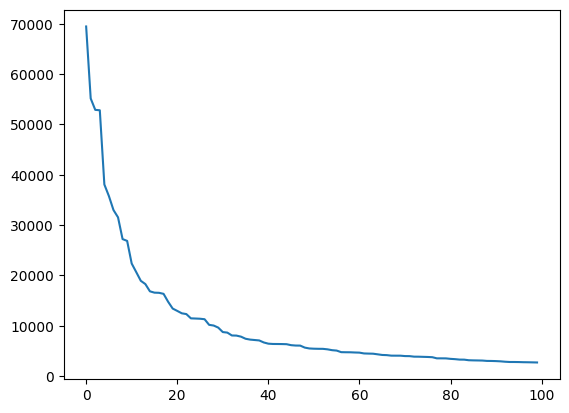

In [43]:
import matplotlib.pyplot as plt
%matplotlib inline
first_100_freqs = [freq for word, freq in freq_dict_sorted[:100]]
plt.plot(first_100_freqs)
plt.show()

Закон Хипса -- обратная сторона закона Ципфа. Он описывает, что чем больше корпус, тем меньше новых слов добавляется с добавлением новых текстов. В какой-то момент корпус насыщается.

## О важности эксплоративного анализа

Но иногда пунктуация бывает и не шумом -- главное отталкиваться от задачи. Что будет, если вообще не убирать пунктуацию?

In [44]:
vec = TfidfVectorizer(ngram_range=(1, 1), tokenizer=word_tokenize)
bow = vec.fit_transform(x_train)
clf = LogisticRegression(random_state=42)
clf.fit(bow, y_train)
pred = clf.predict(vec.transform(x_test))
print(classification_report(pred, y_test))

              precision    recall  f1-score   support

    negative       1.00      1.00      1.00     27940
    positive       1.00      1.00      1.00     28769

    accuracy                           1.00     56709
   macro avg       1.00      1.00      1.00     56709
weighted avg       1.00      1.00      1.00     56709



Шок! Стоило оставить пунктуацию -- и все метрики равны 1. Как это получилось? Среди неё были очень значимые токены (как вы думаете, какие?). Найдите признаки с самыми большими коэффициентами:

Посмотрим, как один из супер-значимых токенов справится с классификацией без всякого машинного обучения:

In [ ]:
cool_token = ')'
pred = ['positive' if cool_token in tweet else 'negative' for tweet in x_test]
print(classification_report(pred, y_test))

              precision    recall  f1-score   support

    negative       1.00      0.85      0.92     32951
    positive       0.83      1.00      0.91     23758

    accuracy                           0.91     56709
   macro avg       0.91      0.93      0.91     56709
weighted avg       0.93      0.91      0.91     56709



## Символьные n-граммы

Теперь в качестве признаков используем, например, униграммы символов:

In [ ]:
vec = CountVectorizer(analyzer='char', ngram_range=(1, 1))
bow = vec.fit_transform(x_train)
clf = LogisticRegression(random_state=42)
clf.fit(bow, y_train)
pred = clf.predict(vec.transform(x_test))
print(classification_report(pred, y_test))

/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_logistic.py:458: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


              precision    recall  f1-score   support

    negative       0.99      1.00      1.00     27688
    positive       1.00      0.99      1.00     29021

    accuracy                           1.00     56709
   macro avg       1.00      1.00      1.00     56709
weighted avg       1.00      1.00      1.00     56709



В общем-то, теперь уже понятно, почему на этих данных здесь 1. Так или иначе, на символах классифицировать тоже можно: для некоторых задач (например, для определения языка) признаки - символьные n-граммы работают очень неплохо.

Ещё одна замечательная особенность признаков-символов: токенизация и лемматизация не нужна, можно использовать такой подход для языков, у которых нет готовых анализаторов.

## Регулярки

(если осталось время)

Вообще, часто бывает так, что для конкретного случая нужен особый способ токенизации, и надо самостоятельно написать регулярку. Или, например, перед работой с текстом, надо почистить его от своеобразного мусора: упоминаний пользователей, url и так далее.

Навык полезный, давайте в нём тоже потренируемся.

In [ ]:
import re

### findall
возвращает список всех найденных совпадений

In [ ]:
result = re.findall('ab+c.', 'abcdefghijkabcabcxabc')
print(result)

['abcd', 'abca']


Вопрос на внимательность: почему нет abcx?

**Задание**: вернуть список первых двух букв каждого слова в строке, состоящей из нескольких слов.

### split
разделяет строку по заданному шаблону


In [ ]:
result = re.split(',', 'itsy, bitsy, teenie, weenie')
print(result)

['itsy', ' bitsy', ' teenie', ' weenie']


можно указать максимальное количество разбиений

In [ ]:
result = re.split(',', 'itsy, bitsy, teenie, weenie', maxsplit = 2)
print(result)

['itsy', ' bitsy', ' teenie, weenie']


**Задание**: разбейте строку, состоящую из нескольких предложений, по точкам, но не более чем на 3 предложения.

In [ ]:
result = re.split(',', 'apple,pear,banana')
print ([a[0] + a[1] for a in result])


['ap', 'pe', 'ba']


### sub
ищет шаблон в строке и заменяет все совпадения на указанную подстроку

параметры: (pattern, repl, string)

In [ ]:
result = re.sub('a', 'b', 'abcabc')
print (result)

bbcbbc


**Задание**: напишите регулярку, которая заменяет все цифры в строке на "DIG".

In [ ]:
result = re.sub('\d', 'DIG', 'abc5ab2c')
print(result)

abcDIGabDIGc


**Задание**: напишите регулярку, которая убирает url из строки.

### compile
компилирует регулярное выражение в отдельный объект

In [ ]:
# Пример: построение списка всех слов строки:
prog = re.compile('[А-Яа-яё\-]+')
prog.findall("Слова? Да, больше, ещё больше слов! Что-то ещё.")

['Слова', 'Да', 'больше', 'ещё', 'больше', 'слов', 'Что-то', 'ещё']

**Задание**: для выбранной строки постройте список слов, которые длиннее трех символов.

**Задание**: вернуть список доменов (@gmail.com) из списка адресов электронной почты:

```
abc.test@gmail.com, xyz@test.in, test.first@analyticsvidhya.com, first.test@rest.biz
```

Если всё ещё осталось время: [регулярочный кроссворд ¯\_(ツ)_/¯](https://mariolurig.com/crossword/)